# 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column 'price').

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv) or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv) if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

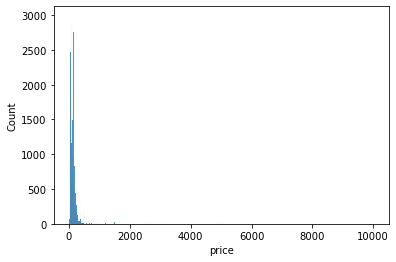

In [3]:
sns.histplot(df.price)
plt.show()

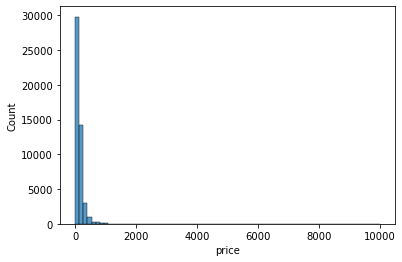

In [4]:
sns.histplot(df.price, bins=75)
plt.show()

* Apply the log tranform to price
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1

In [5]:
 df.price = np.log1p(df.price.values)

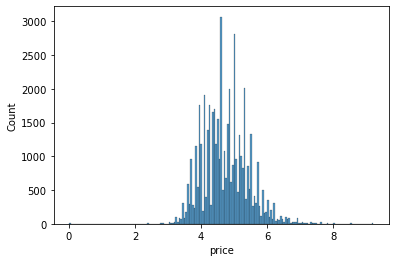

In [6]:
sns.histplot(df.price)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = (df_train.price).values
y_val = (df_val.price).values
y_test = (df_test.price).values

In [10]:
del df_train['price']
del df_val['price']
del df_test['price']
df_train.head(3)

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Queens,40.76434,-73.92132,Entire home/apt,4,30,0.32,1,363
1,Brooklyn,40.73442,-73.95854,Private room,5,2,0.16,1,0
2,Brooklyn,40.66359,-73.99487,Entire home/apt,1,33,2.75,5,113


Now, use DictVectorizer to turn train and validation into matrices:

In [11]:
from sklearn.feature_extraction import DictVectorizer

In [12]:
train_dicts = df_train.fillna(0).to_dict(orient='records')


In [13]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [14]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

# Question 1
Let's train a decision tree regressor to predict the price variable.

* Train a model with max_depth=1

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score,  r2_score, roc_auc_score
from sklearn.tree import export_text
from sklearn import tree

In [17]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [18]:
y_pred = dtr.predict(X_train)
acc = r2_score(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print('R2 train:', acc)
print('RMSE train:', rmse)
print('--------------')
y_pred_2 = dtr.predict(X_val)
acc_v = r2_score(y_val, y_pred_2)
rmse_2 = mean_squared_error(y_val, y_pred_2, squared=False)
print('R2 val:', acc_v)
print('RMSE val:', rmse_2)


R2 train: 0.3772557496442457
RMSE train: 0.5496412649960563
--------------
R2 val: 0.3897141978123895
RMSE val: 0.5488190627763704


In [19]:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



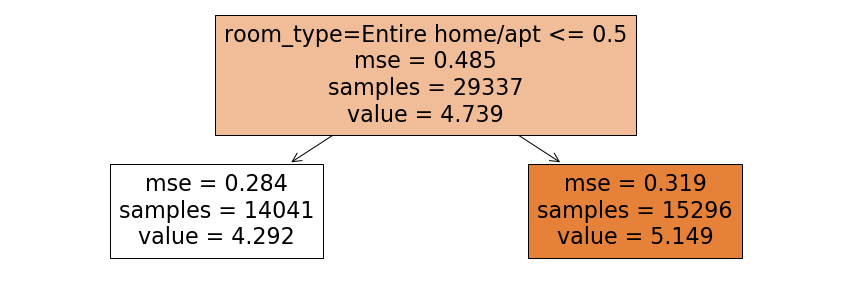

In [20]:
# visualize the decision tree
fig = plt.figure(figsize=(15,5))
plot = tree.plot_tree(dtr, feature_names=dv.get_feature_names(), filled=True)

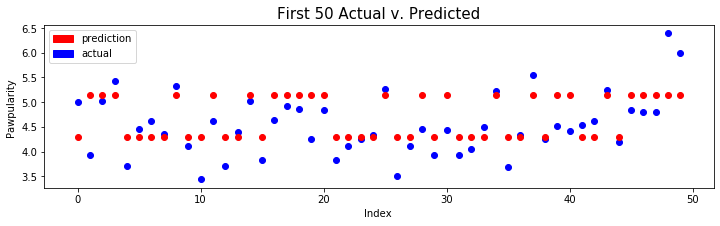

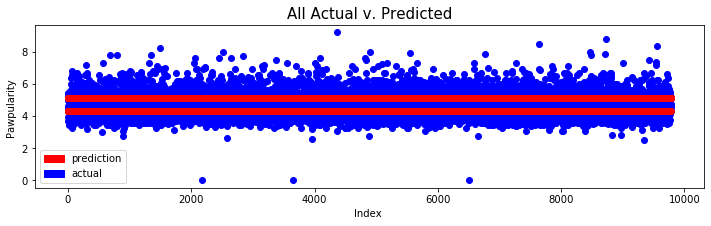

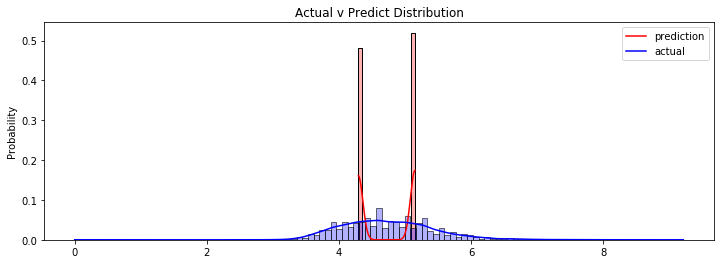

In [21]:
#let's see what our predictions look like vs the actual 
def ActualvPredictionsGraph(y_test,y_pred,title):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return

#plot it
ActualvPredictionsGraph(y_val[0:50], y_pred_2[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_val, y_pred_2, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(y_pred_2,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

# Answer 1 

Which feature is used for splitting the data?

* [X] room_type ,is the correct answer
* neighbourhood_group
* number_of_reviews
* reviews_per_month

# Question 2
Train a random forest model with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

In [25]:
from sklearn.ensemble import RandomForestRegressor 

In [26]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1) # DecisionTreeRegressor doesn't have n_estimators or n_jobs as arguments
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [28]:
rf_y_pred_t = rfr.predict(X_train)
acc_t = r2_score(y_train, rf_y_pred_t)
rmse_t = mean_squared_error(y_train, rf_y_pred_t, squared=False)
print('R2 train:', acc_t)
print('RMSE train:', rmse_t)
print('--------------')
rf_y_pred_v = rfr.predict(X_val)
acc_v = r2_score(y_val, rf_y_pred_v)
rmse_v = mean_squared_error(y_val, rf_y_pred_v, squared=False)
print('R2 val:', acc_v)
print('RMSE val:', rmse_v)


R2 train: 0.9185016301036522
RMSE train: 0.19883779038400198
--------------
R2 val: 0.5696440483329448
RMSE val: 0.46086790130720745


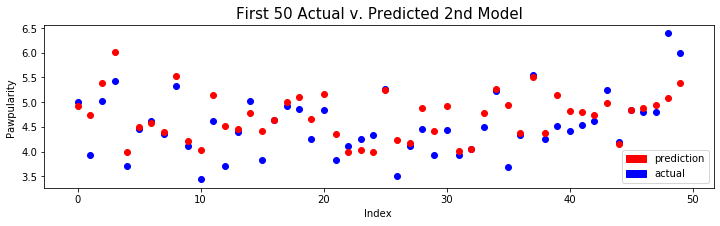

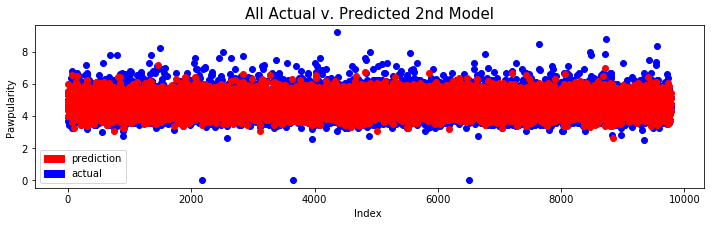

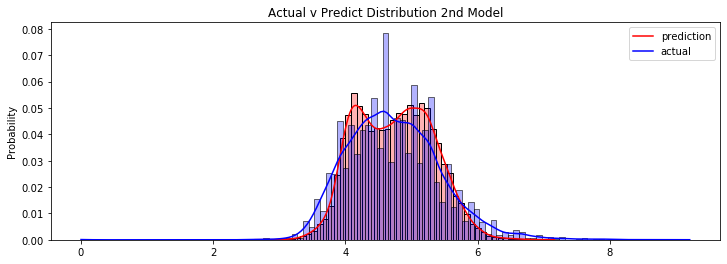

In [29]:
#plot it
ActualvPredictionsGraph(y_val[0:50], rf_y_pred_v[0:50], "First 50 Actual v. Predicted 2nd Model")
ActualvPredictionsGraph(y_val, rf_y_pred_v, "All Actual v. Predicted 2nd Model")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(rf_y_pred_v,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution 2nd Model')
plt.show()

# Answer 2
What's the RMSE of this model on validation?

* 0.059
* 0.259
* [X] 0.459
* 0.659 the correct answer

# Question 3
Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set random_state to 1
* Evaluate the model on the validation dataset

In [32]:
rmses = []

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1)
    rf.fit(X_train, y_train)
    y_pred_v = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred_v, squared=False)
    print('n_estimators = %s -> rmse=  %.3f' % (i, rmse))
    rmses.append(rmse)

n_estimators = 10 -> rmse=  0.461
n_estimators = 20 -> rmse=  0.447
n_estimators = 30 -> rmse=  0.444
n_estimators = 40 -> rmse=  0.443
n_estimators = 50 -> rmse=  0.442
n_estimators = 60 -> rmse=  0.441
n_estimators = 70 -> rmse=  0.441
n_estimators = 80 -> rmse=  0.441
n_estimators = 90 -> rmse=  0.440
n_estimators = 100 -> rmse=  0.440
n_estimators = 110 -> rmse=  0.439
n_estimators = 120 -> rmse=  0.439
n_estimators = 130 -> rmse=  0.439
n_estimators = 140 -> rmse=  0.439
n_estimators = 150 -> rmse=  0.439
n_estimators = 160 -> rmse=  0.439
n_estimators = 170 -> rmse=  0.439
n_estimators = 180 -> rmse=  0.439
n_estimators = 190 -> rmse=  0.439
n_estimators = 200 -> rmse=  0.439


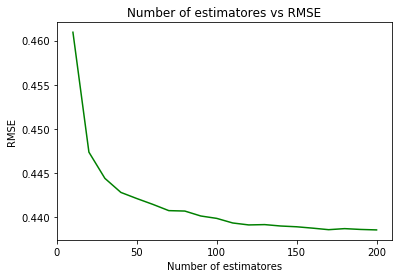

In [62]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), rmses, color='green')
plt.xticks(range(0, 201, 50))

plt.title('Number of estimatores vs RMSE')
plt.xlabel('Number of estimatores')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

# Answer 3
After which value of n_estimators does RMSE stop improving?

* 10
* 50
* 70
* [X] 120

# Question 4
Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
* Fix the random seed: random_state=1

In [33]:
all_rmses = {}

for depth in [10, 15, 20, 25]:
    print('max_depth: %s' % depth)
    rmses = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred_v = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred_v, squared=False)
        print('n_estimators = %s -> rmse=  %.3f' % (i, rmse))
        rmses.append(rmse)
    
    all_rmses[depth] = rmses
    print()

max_depth: 10
n_estimators = 10 -> rmse=  0.445
n_estimators = 20 -> rmse=  0.442
n_estimators = 30 -> rmse=  0.441
n_estimators = 40 -> rmse=  0.441
n_estimators = 50 -> rmse=  0.441
n_estimators = 60 -> rmse=  0.441
n_estimators = 70 -> rmse=  0.441
n_estimators = 80 -> rmse=  0.441
n_estimators = 90 -> rmse=  0.440
n_estimators = 100 -> rmse=  0.440
n_estimators = 110 -> rmse=  0.440
n_estimators = 120 -> rmse=  0.440
n_estimators = 130 -> rmse=  0.440
n_estimators = 140 -> rmse=  0.440
n_estimators = 150 -> rmse=  0.440
n_estimators = 160 -> rmse=  0.440
n_estimators = 170 -> rmse=  0.440
n_estimators = 180 -> rmse=  0.440
n_estimators = 190 -> rmse=  0.440
n_estimators = 200 -> rmse=  0.440

max_depth: 15
n_estimators = 10 -> rmse=  0.450
n_estimators = 20 -> rmse=  0.441
n_estimators = 30 -> rmse=  0.440
n_estimators = 40 -> rmse=  0.439
n_estimators = 50 -> rmse=  0.438
n_estimators = 60 -> rmse=  0.438
n_estimators = 70 -> rmse=  0.437
n_estimators = 80 -> rmse=  0.437
n_estima

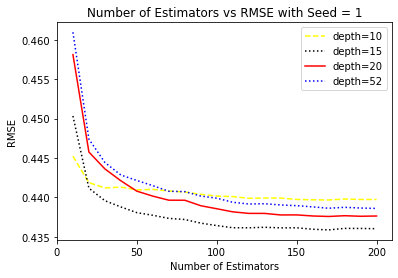

In [59]:
plt.figure(figsize=(6, 4))

num_estimators = list(range(10, 201, 10))

plt.plot(num_estimators, all_rmses[10], label='depth=10', color='yellow', linestyle='dashed')
plt.plot(num_estimators, all_rmses[15], label='depth=15', color='black', linestyle='dotted')
plt.plot(num_estimators, all_rmses[20], label='depth=20', color='red', linestyle='solid')
plt.plot(num_estimators, all_rmses[25], label='depth=52', color='blue', linestyle='dotted')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of Estimators vs RMSE with Seed = 1')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

In [36]:
%%time
all_rmses2 = {}
print('Experimenting with Random State = 3')
for depth in [10, 15, 20, 25]:
    print('max_depth: %s' % depth)
    rmses2 = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=3)
        rf.fit(X_train, y_train)
        y_pred_v = rf.predict(X_val)
        rmse2 = mean_squared_error(y_val, y_pred_v, squared=False)
        print('n_estimators = %s -> rmse=  %.3f' % (i, rmse2))
        rmses2.append(rmse2)
    
    all_rmses2[depth] = rmses2
    print()

Experimenting with Random State = 3
max_depth: 10
n_estimators = 10 -> rmse=  0.444
n_estimators = 20 -> rmse=  0.441
n_estimators = 30 -> rmse=  0.440
n_estimators = 40 -> rmse=  0.440
n_estimators = 50 -> rmse=  0.440
n_estimators = 60 -> rmse=  0.440
n_estimators = 70 -> rmse=  0.439
n_estimators = 80 -> rmse=  0.439
n_estimators = 90 -> rmse=  0.439
n_estimators = 100 -> rmse=  0.440
n_estimators = 110 -> rmse=  0.439
n_estimators = 120 -> rmse=  0.440
n_estimators = 130 -> rmse=  0.440
n_estimators = 140 -> rmse=  0.439
n_estimators = 150 -> rmse=  0.439
n_estimators = 160 -> rmse=  0.439
n_estimators = 170 -> rmse=  0.439
n_estimators = 180 -> rmse=  0.439
n_estimators = 190 -> rmse=  0.439
n_estimators = 200 -> rmse=  0.439

max_depth: 15
n_estimators = 10 -> rmse=  0.451
n_estimators = 20 -> rmse=  0.441
n_estimators = 30 -> rmse=  0.439
n_estimators = 40 -> rmse=  0.438
n_estimators = 50 -> rmse=  0.438
n_estimators = 60 -> rmse=  0.437
n_estimators = 70 -> rmse=  0.437
n_esti

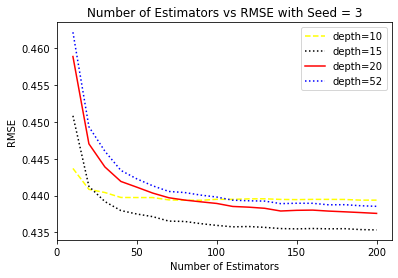

In [60]:
plt.figure(figsize=(6, 4))

num_estimators = list(range(10, 201, 10))

plt.plot(num_estimators, all_rmses2[10], label='depth=10', color='yellow', linestyle='dashed')
plt.plot(num_estimators, all_rmses2[15], label='depth=15', color='black', linestyle='dotted')
plt.plot(num_estimators, all_rmses2[20], label='depth=20', color='red', linestyle='solid')
plt.plot(num_estimators, all_rmses2[25], label='depth=52', color='blue', linestyle='dotted')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of Estimators vs RMSE with Seed = 3')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

# Answer 4
What's the best max_depth:

* 10
* [X] 15
* 20
* 25
Bonus question (not graded):

Will the answer be different if we change the seed for the model?

* [X] Well I think after changing the seed it didn't change at all the model rmse of each max_depth.

# Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * n_estimators=10,
    * max_depth=20,
    * random_state=1,
    * n_jobs=-1 (optional)
* Get the feature importance information from this model

In [37]:
%%time
n = 10
depth = 20
model_rf = RandomForestRegressor(n_estimators= n, max_depth=depth, random_state=1,n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_val = model_rf.predict(X_val)
rmse_model = mean_squared_error(y_val, y_pred_val, squared=False)
print('n_estimators = %s -> depth = %s -> rmse=  %.3f' % (n,depth, rmse_model))

n_estimators = 10 -> depth = 20 -> rmse=  0.458
Wall time: 811 ms


In [39]:
print('feature importance: \n ')
model_rf.feature_importances_

feature importance: 
 


array([7.63357153e-02, 3.09505091e-02, 1.52019245e-01, 1.53589062e-01,
       5.36665764e-02, 2.45893394e-04, 1.10306405e-03, 3.41355484e-02,
       1.16220988e-03, 1.26504611e-04, 4.30439805e-02, 5.26597110e-02,
       3.91896832e-01, 4.57684075e-03, 4.48830753e-03])

In [49]:
list(zip(dv.feature_names_, model_rf.feature_importances_))

[('availability_365', 0.07633571528032997),
 ('calculated_host_listings_count', 0.03095050908784188),
 ('latitude', 0.1520192453235052),
 ('longitude', 0.15358906161021965),
 ('minimum_nights', 0.05366657644840592),
 ('neighbourhood_group=Bronx', 0.0002458933943452799),
 ('neighbourhood_group=Brooklyn', 0.0011030640502402431),
 ('neighbourhood_group=Manhattan', 0.03413554841532697),
 ('neighbourhood_group=Queens', 0.0011622098782235392),
 ('neighbourhood_group=Staten Island', 0.00012650461086170805),
 ('number_of_reviews', 0.043043980480961926),
 ('reviews_per_month', 0.052659710954611125),
 ('room_type=Entire home/apt', 0.3918968321897941),
 ('room_type=Private room', 0.004576840746812984),
 ('room_type=Shared room', 0.0044883075285197215)]

In [50]:
#feature importances based on analysis using random forest
featureImp = pd.DataFrame({'feature': dv.feature_names_,
                'Score': model_rf.feature_importances_
            })
sortedFeatureImp = featureImp.sort_values('Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sortedFeatureImp.style.highlight_max(axis=0)

,feature,Score
12,room_type=Entire home/apt,0.391897
3,longitude,0.153589
2,latitude,0.152019
0,availability_365,0.076336
4,minimum_nights,0.053667
11,reviews_per_month,0.052660
10,number_of_reviews,0.043044
7,neighbourhood_group=Manhattan,0.034136
1,calculated_host_listings_count,0.030951
13,room_type=Private room,0.004577


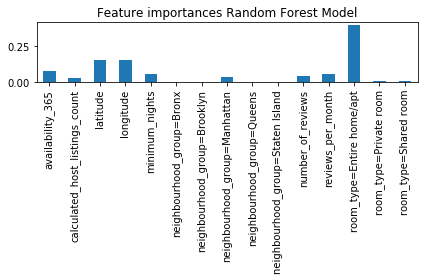

In [55]:
forest_importances = pd.Series(model_rf.feature_importances_, index=dv.feature_names_)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances Random Forest Model")
fig.tight_layout()

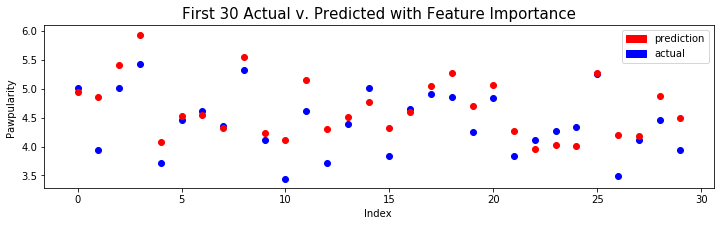

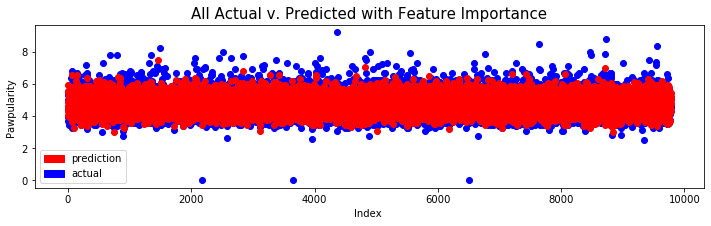

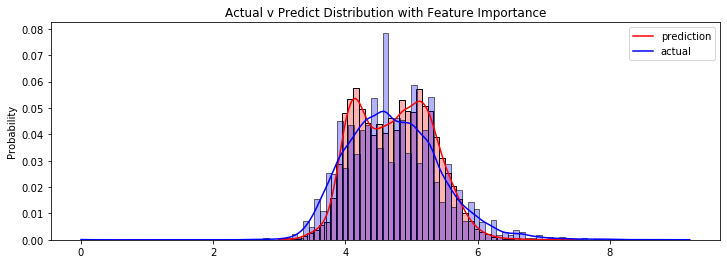

In [40]:
#plot it
ActualvPredictionsGraph(y_val[0:30], y_pred_val[0:30], "First 30 Actual v. Predicted with Feature Importance")
ActualvPredictionsGraph(y_val, y_pred_val, "All Actual v. Predicted with Feature Importance")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(y_pred_val,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution with Feature Importance')
plt.show()

# Answer 5 

What's the most important feature?

* neighbourhood_group=Manhattan
* [X] room_type=Entire home/apt  -- the correct answer.
* longitude
* latitude

# Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

    xgb_params = 

    {
    
        'eta': 0.3, 

        'max_depth': 6,

        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

In [116]:
import xgboost as xgb

In [117]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

## ETA = 0.3

In [118]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [119]:
%%time
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

Wall time: 2.03 s


In [120]:
y_pred = model.predict(dval)
y_pred[:10]

array([4.7513413, 4.7776213, 5.3586164, 5.594756 , 3.8833497, 4.785674 ,
       4.8172717, 4.05857  , 5.476615 , 4.339413 ], dtype=float32)

In [122]:
all_xgb_rmses = {}
xgb_rmses = []

In [124]:
rmse1 = mean_squared_error(y_val, y_pred, squared=False)
xgb_rmses.append(rmse1)
print("ETA = 0.3 -> RMSE= {}".format(rmse1))

ETA = 0.3 -> RMSE= 0.43621034591295677


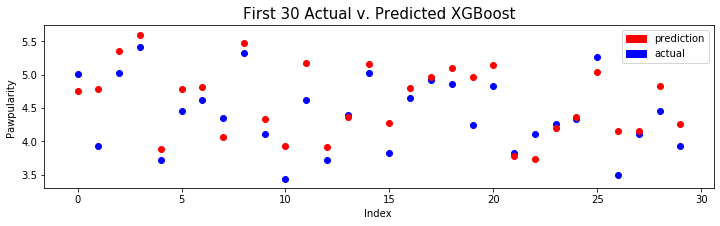

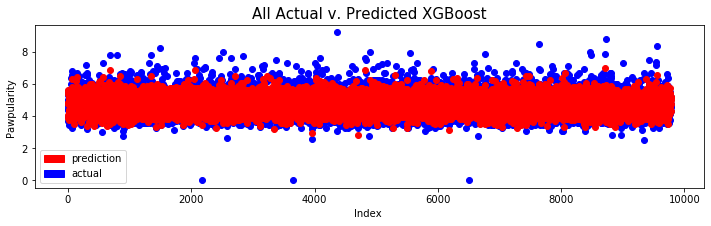

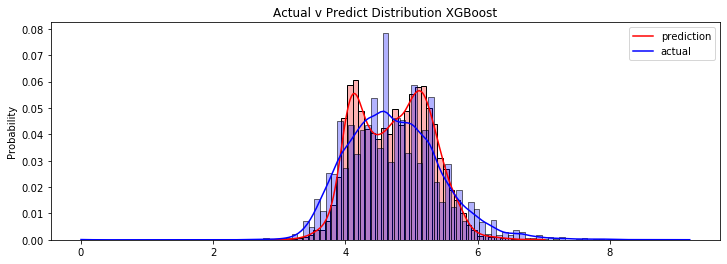

In [125]:
#plot it
ActualvPredictionsGraph(y_val[0:30], y_pred[0:30], "First 30 Actual v. Predicted XGBoost")
ActualvPredictionsGraph(y_val, y_pred, "All Actual v. Predicted XGBoost")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(y_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution XGBoost')
plt.show()

In [126]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('room_type=Entire home/apt', 136.60199355595452),
 ('neighbourhood_group=Manhattan', 38.77857149170769),
 ('room_type=Private room', 4.40398193572973),
 ('longitude', 2.404942811363384),
 ('latitude', 1.804999785843256),
 ('minimum_nights', 1.63273024232617),
 ('calculated_host_listings_count', 1.6038875484175144),
 ('availability_365', 1.3011695591491867),
 ('room_type=Shared room', 1.1802525067625),
 ('reviews_per_month', 1.1352082444579183),
 ('neighbourhood_group=Bronx', 1.1014466251111112),
 ('number_of_reviews', 1.0632138272444982),
 ('neighbourhood_group=Brooklyn', 0.7766648204900001),
 ('neighbourhood_group=Queens', 0.22969028322499999)]

In [127]:
scores_w = model.get_score(importance_type='weight')
scores_w = sorted(scores_w.items(), key=lambda x: x[1])
list(reversed(scores_w))

[('latitude', 1159),
 ('longitude', 1075),
 ('availability_365', 782),
 ('reviews_per_month', 437),
 ('number_of_reviews', 389),
 ('minimum_nights', 388),
 ('calculated_host_listings_count', 312),
 ('room_type=Entire home/apt', 77),
 ('room_type=Private room', 37),
 ('room_type=Shared room', 16),
 ('neighbourhood_group=Manhattan', 13),
 ('neighbourhood_group=Brooklyn', 10),
 ('neighbourhood_group=Bronx', 9),
 ('neighbourhood_group=Queens', 8)]

In [128]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

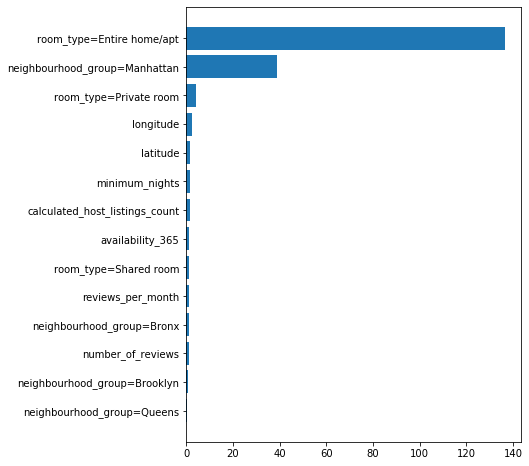

In [129]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

## ETA = 0.1 

In [130]:
xgb_params2 = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [131]:
%%time
model2 = xgb.train(xgb_params2, dtrain, num_boost_round=100)

Wall time: 2.23 s


In [132]:
y_pred2 = model2.predict(dval)
y_pred2[:10]

array([4.7540293, 4.7860737, 5.346066 , 5.715779 , 3.947337 , 4.800967 ,
       4.2272124, 4.085346 , 5.4654264, 4.3502526], dtype=float32)

In [133]:
rmse2 = mean_squared_error(y_val, y_pred2, squared=False)
xgb_rmses.append(rmse2)
print("ETA = 0.1 -> RMSE= {}".format(rmse2))

ETA = 0.1 -> RMSE= 0.43249655247991464


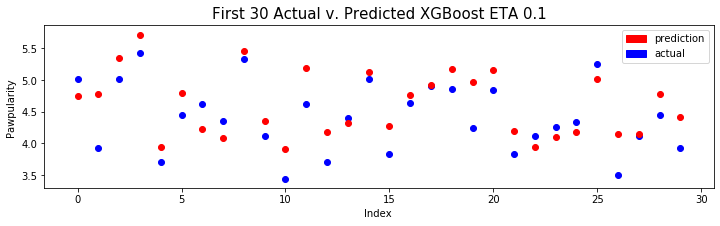

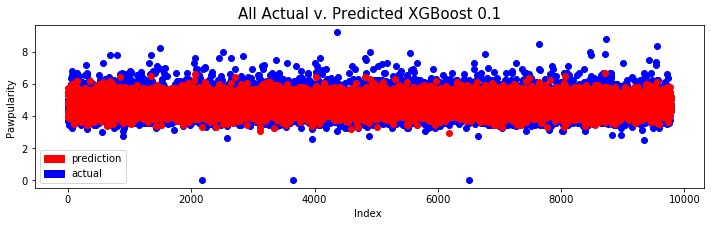

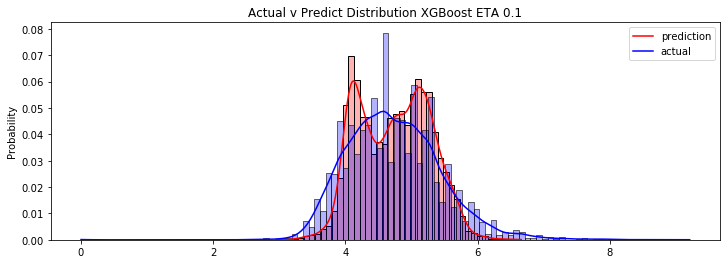

In [134]:
#plot it
ActualvPredictionsGraph(y_val[0:30], y_pred2[0:30], "First 30 Actual v. Predicted XGBoost ETA 0.1")
ActualvPredictionsGraph(y_val, y_pred2, "All Actual v. Predicted XGBoost 0.1")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(y_pred2,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution XGBoost ETA 0.1')
plt.show()

In [135]:
scores2 = model2.get_score(importance_type='gain')
scores2 = sorted(scores2.items(), key=lambda x: x[1])
list(reversed(scores2))

[('room_type=Entire home/apt', 361.1547677723885),
 ('neighbourhood_group=Manhattan', 98.76468634729999),
 ('room_type=Private room', 6.21567917234507),
 ('longitude', 5.41233327509756),
 ('latitude', 3.7423497506340455),
 ('minimum_nights', 2.7970958646413604),
 ('availability_365', 2.596080243010775),
 ('calculated_host_listings_count', 2.155144918813529),
 ('number_of_reviews', 2.1090958894052725),
 ('reviews_per_month', 1.687479435703191),
 ('neighbourhood_group=Queens', 1.4384599955874997),
 ('neighbourhood_group=Brooklyn', 1.19832719029),
 ('neighbourhood_group=Bronx', 1.1828688506923077),
 ('room_type=Shared room', 0.9059209577499999)]

In [136]:
scores_w2 = model2.get_score(importance_type='weight')
scores_w2 = sorted(scores_w2.items(), key=lambda x: x[1])
list(reversed(scores_w2))

[('latitude', 1116),
 ('longitude', 1059),
 ('availability_365', 817),
 ('minimum_nights', 513),
 ('calculated_host_listings_count', 484),
 ('reviews_per_month', 456),
 ('number_of_reviews', 423),
 ('room_type=Entire home/apt', 78),
 ('room_type=Private room', 71),
 ('room_type=Shared room', 28),
 ('neighbourhood_group=Brooklyn', 15),
 ('neighbourhood_group=Manhattan', 15),
 ('neighbourhood_group=Bronx', 13),
 ('neighbourhood_group=Queens', 8)]

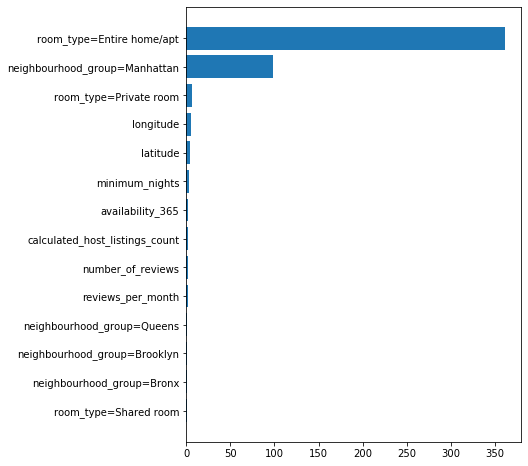

In [137]:
names = [n for (n, s) in scores2]
scores2 = [s for (n, s) in scores2]

plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores2)), scores2)
plt.yticks(np.arange(len(names)), names)

plt.show()

In [ ]:
## ETA = 0.01

In [138]:
xgb_params3 = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [139]:
%%time
model3 = xgb.train(xgb_params3, dtrain, num_boost_round=100)

Wall time: 2.33 s


In [140]:
y_pred3 = model3.predict(dval)
y_pred3[:10]

array([3.1885078, 3.2378414, 3.5531337, 3.7693841, 2.7636592, 3.2155628,
       2.9343657, 2.776457 , 3.6645248, 2.939762 ], dtype=float32)

In [141]:
rmse3 = mean_squared_error(y_val, y_pred3, squared=False)
xgb_rmses.append(rmse3)
print("ETA = 0.1 -> RMSE= {}".format(rmse3))

ETA = 0.1 -> RMSE= 1.630452438951798


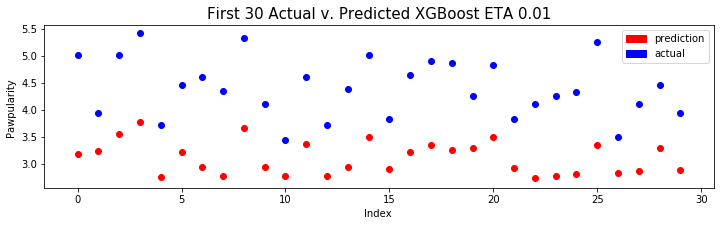

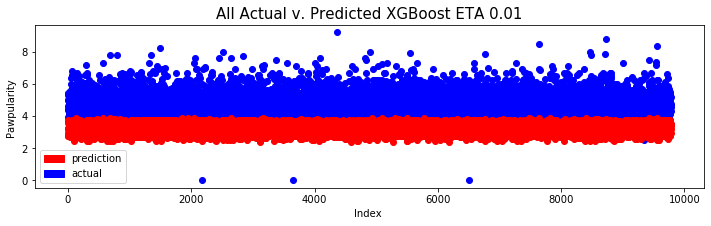

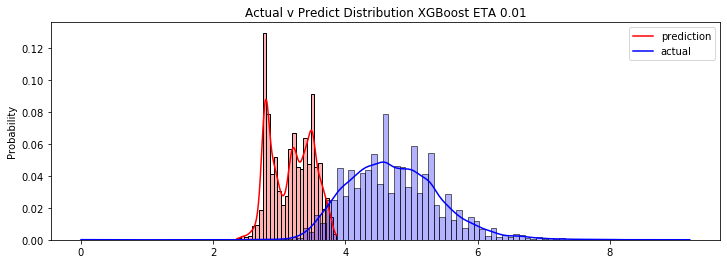

In [111]:
#plot it
ActualvPredictionsGraph(y_val[0:30], y_pred3[0:30], "First 30 Actual v. Predicted XGBoost ETA 0.01")
ActualvPredictionsGraph(y_val, y_pred3, "All Actual v. Predicted XGBoost ETA 0.01")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(y_pred3,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_val,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution XGBoost ETA 0.01')
plt.show()

In [142]:
scores3 = model3.get_score(importance_type='gain')
scores3 = sorted(scores3.items(), key=lambda x: x[1])
list(reversed(scores3))

[('room_type=Entire home/apt', 2328.130626260003),
 ('neighbourhood_group=Manhattan', 266.45736940000006),
 ('longitude', 60.2566480471835),
 ('latitude', 24.799553787713368),
 ('room_type=Private room', 12.201588574868003),
 ('availability_365', 9.526716139900788),
 ('minimum_nights', 5.644390400747276),
 ('number_of_reviews', 4.508294593542531),
 ('calculated_host_listings_count', 3.9355030230551664),
 ('reviews_per_month', 3.2143955899125554),
 ('neighbourhood_group=Queens', 3.1995849649999997),
 ('neighbourhood_group=Bronx', 0.9556732192499999)]

In [143]:
scores_w3 = model3.get_score(importance_type='weight')
scores_w3 = sorted(scores_w3.items(), key=lambda x: x[1])
list(reversed(scores_w3))

[('latitude', 854),
 ('availability_365', 808),
 ('minimum_nights', 708),
 ('longitude', 565),
 ('number_of_reviews', 355),
 ('reviews_per_month', 262),
 ('calculated_host_listings_count', 238),
 ('room_type=Private room', 222),
 ('room_type=Entire home/apt', 100),
 ('neighbourhood_group=Manhattan', 52),
 ('neighbourhood_group=Bronx', 8),
 ('neighbourhood_group=Queens', 2)]

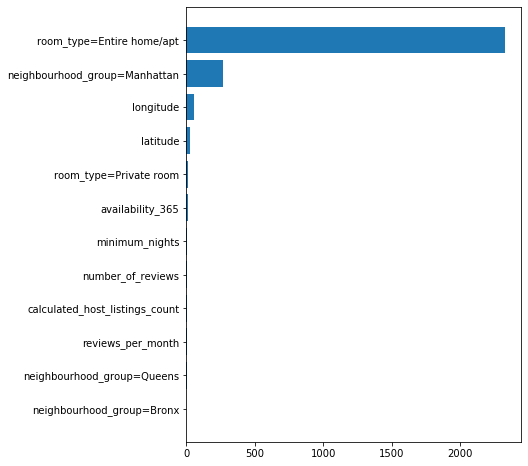

In [144]:
names = [n for (n, s) in scores3]
scores3 = [s for (n, s) in scores3]

plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores3)), scores3)
plt.yticks(np.arange(len(names)), names)

plt.show()

In [147]:
etas = [0.3 , 0.1 , 0.01]

In [148]:
all_xgb_rmses[etas[0]] = xgb_rmses[0]
all_xgb_rmses[etas[1]] = xgb_rmses[1]
all_xgb_rmses[etas[2]] = xgb_rmses[2]

In [146]:
xgb_rmses

[0.43621034591295677, 0.43249655247991464, 1.630452438951798]

In [149]:
all_xgb_rmses

{0.3: 0.43621034591295677, 0.1: 0.43249655247991464, 0.01: 1.630452438951798}

# Answer 6

What's the best eta?

* 0.3
* [X] 0.1 -- correct Answer.
* 0.01